# General Introduction to Reservoir Computing

## Summary

- <a href="#chapitre1">Chapter 1 : A simple task</a>
- <a href="#chapitre2">Chapter 2 : Generative models</a>
- <a href="#chapitre3">Chapter 3 : Online learning</a>

In [1]:
import sys
sys.path.append("..")

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import reservoirpy as rpy

# just a little tweak to center the plots, nothing to worry about
from IPython.core.display import HTML
HTML("""
<style>
.img-center {
    display: block;
    margin-left: auto;
    margin-right: auto;
    }
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    }
</style>
""")

rpy.set_seed(42)

## Chapter 1 : Reservoir Computing for chaotic timeseries forecasting <span id="chapitre1"/>

**Mackey-Glass timeseries**

Mackey-Glass equation are a set of delayed differential equations
describing the temporal behaviour of different physiological signal,
for example, the relative quantity of mature blood cells over time.

The equations are defined as:

$$
\frac{dP(t)}{dt} = \frac{a P(t - \tau)}{1 + P(t - \tau)^n} - bP(t)
$$

where $a = 0.2$, $b = 0.1$, $n = 10$, and the time delay $\tau = 17$.
$\tau$ controls the chaotic behaviour of the equations (the higher it is,
the more chaotic the timeserie becomes.
$\tau=17$ already gives good chaotic results.)

In [79]:
from reservoirpy.datasets import mackey_glass
from reservoirpy.observables import nrmse, rsquare

timesteps = 2510
tau = 17
X = mackey_glass(timesteps, tau=tau)

# rescale between -1 and 1
X = 2 * (X - X.min()) / (X.max() - X.min()) - 1

In [3]:
def plot_mackey_glass(X, sample, tau):

    fig = plt.figure(figsize=(13, 5))
    N = sample

    ax = plt.subplot((121))
    t = np.linspace(0, N, N)
    for i in range(N-1):
        ax.plot(t[i:i+2], X[i:i+2], color=plt.cm.magma(255*i//N), lw=1.0)

    plt.title(f"Timeseries - {N} timesteps")
    plt.xlabel("$t$")
    plt.ylabel("$P(t)$")

    ax2 = plt.subplot((122))
    ax2.margins(0.05)
    for i in range(N-1):
        ax2.plot(X[i:i+2], X[i+tau:i+tau+2], color=plt.cm.magma(255*i//N), lw=1.0)

    plt.title(f"Phase diagram: $P(t) = f(P(t-\\tau))$")
    plt.xlabel("$P(t-\\tau)$")
    plt.ylabel("$P(t)$")

    plt.tight_layout()
    plt.show()

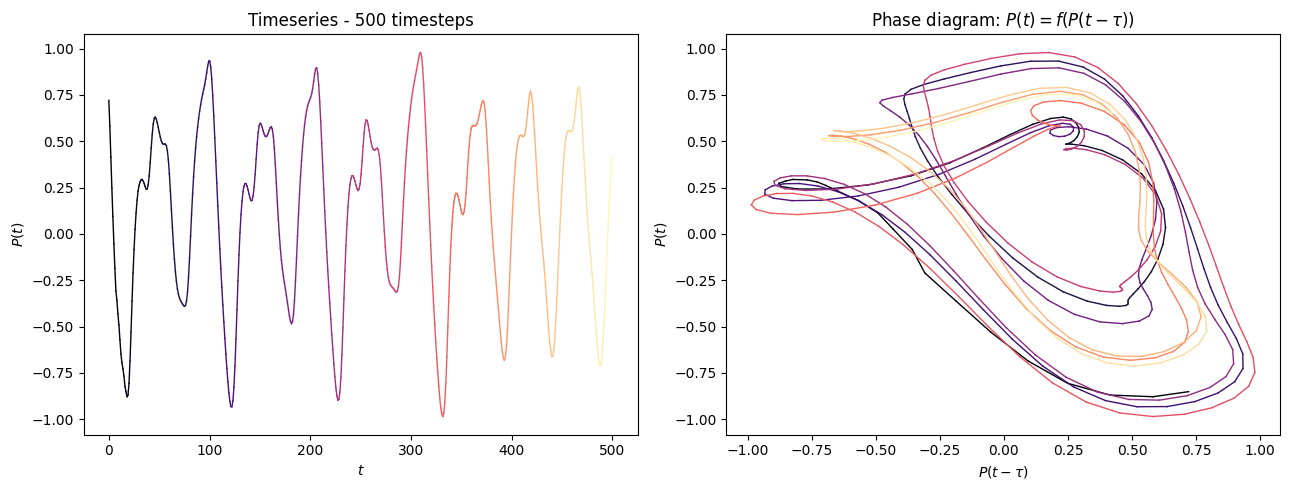

In [4]:
plot_mackey_glass(X, 500, tau)

- Not completely unpredictable... (not random)
- ...but not easily predictable (not periodic)
- Similar to ECG rythms, stocks, weather...

### 1.1. Task 1: 10 timesteps ahead forecast

Predict $P(t + 10)$ given $P(t)$.

#### Data preprocessing

In [5]:
def plot_train_test(X_train, y_train, X_test, y_test):
    sample = 500
    test_len = X_test.shape[0]
    fig = plt.figure(figsize=(15, 5))
    plt.plot(np.arange(0, 500), X_train[-sample:], label="Training data")
    plt.plot(np.arange(0, 500), y_train[-sample:], label="Training ground truth")
    plt.plot(np.arange(500, 500+test_len), X_test, label="Testing data")
    plt.plot(np.arange(500, 500+test_len), y_test, label="Testing ground truth")
    plt.legend()
    plt.show()

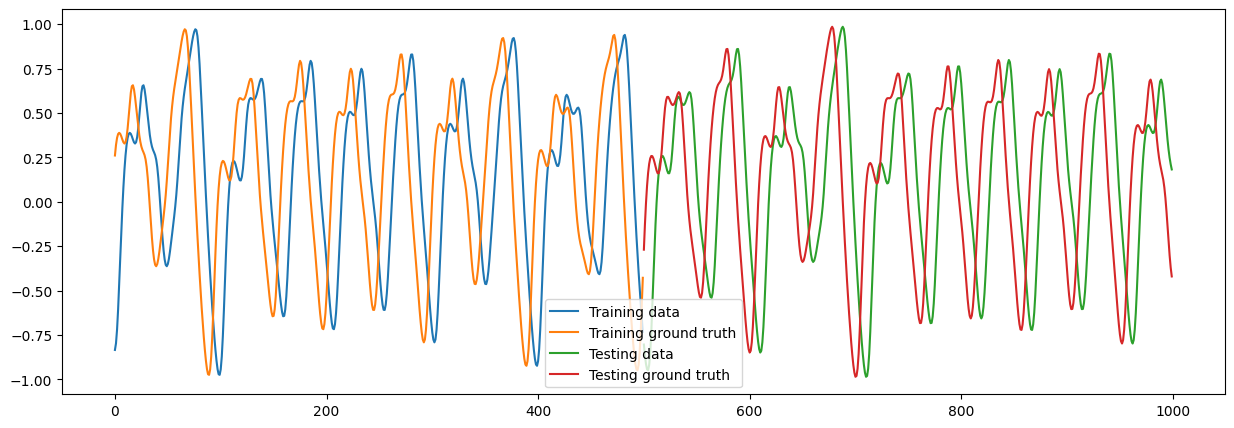

In [6]:
from reservoirpy.datasets import to_forecasting

x, y = to_forecasting(X, forecast=10)
X_train1, y_train1 = x[:2000], y[:2000]
X_test1, y_test1 = x[2000:], y[2000:]

plot_train_test(X_train1, y_train1, X_test1, y_test1)

### Build your first Echo State Network

In [7]:
units = 100
leak_rate = 0.3
spectral_radius = 1.25
input_scaling = 1.0
connectivity = 0.1
input_connectivity = 0.2
regularization = 1e-8
seed = 1234

In [8]:
def reset_esn():
    from reservoirpy.nodes import Reservoir, Ridge

    reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                          lr=leak_rate, rc_connectivity=connectivity,
                          input_connectivity=input_connectivity, seed=seed)
    readout   = Ridge(1, ridge=regularization)

    return reservoir >> readout, reservoir

In [9]:
import numpy as np

def get_forwardized_weights(W):
    """"
    Input recurrent weight matrix is folded along the diagonal and values are inserted into the lower triangle when there is a zero.
    This turns a recurrent neural network into its feedforward weight representation by inverting the connections that make the network cyclic.
    """
    triuW = np.triu(W)
    foldW = np.tril(W)

    zero_indices = foldW == 0
    foldW[zero_indices] = triuW.T[zero_indices]

    foldW[np.diag_indices(foldW.shape[0])] = 0 # cancel self connections

    return foldW

In [10]:
from reservoirpy.nodes import Reservoir, Ridge

reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                      lr=leak_rate, rc_connectivity=connectivity,
                      input_connectivity=input_connectivity, seed=seed)

readout   = Ridge(1, ridge=regularization)

esn = reservoir >> readout

In [11]:
y = esn(X[0])  # initialisation

denseW = reservoir.W.toarray()
# denseW = denseW * 0.1

denseW = get_forwardized_weights(denseW)

# denseW = denseW + np.identity(denseW.shape[0])
from scipy import sparse

sparseW = sparse.csr_matrix(denseW)

reservoir.W = sparseW

reservoir.Win is not None, reservoir.W is not None, readout.Wout is not None

(True, True, True)

In [12]:
show1 = reservoir.W.toarray()

In [13]:
from reservoirpy.observables import spectral_radius
print(spectral_radius(show1)) # eigenvalues of lower-triangular are the diagonal elements, and these are all zero

0.0


In [14]:
np.all(readout.Wout == 0.0)

True

#### ESN training

Training is performed *offline*: it happens only once on the whole dataset.

In [15]:
esn = esn.fit(X_train1, y_train1)

Running Model-0: 2000it [00:00, 9117.67it/s]<?, ?it/s]
Running Model-0: 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


Fitting node Ridge-0...


In [16]:
def plot_readout(readout):
    Wout = readout.Wout
    bias = readout.bias
    Wout = np.r_[bias, Wout]

    fig = plt.figure(figsize=(15, 5))

    ax = fig.add_subplot(111)
    ax.grid(axis="y")
    ax.set_ylabel("Coefs. of $W_{out}$")
    ax.set_xlabel("reservoir neurons index")
    ax.bar(np.arange(Wout.size), Wout.ravel()[::-1])

    plt.show()

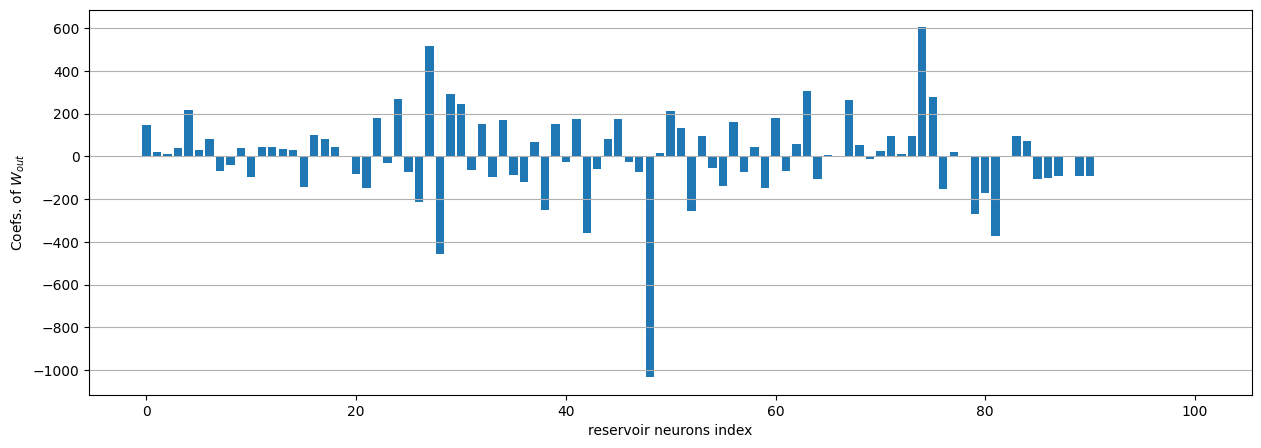

In [17]:
plot_readout(readout)

#### ESN test

In [18]:
def plot_results(y_pred, y_test, sample=500):

    fig = plt.figure(figsize=(15, 7))
    plt.subplot(211)
    plt.plot(np.arange(sample), y_pred[:sample], lw=3, label="ESN prediction")
    plt.plot(np.arange(sample), y_test[:sample], linestyle="--", lw=2, label="True value")
    plt.plot(np.abs(y_test[:sample] - y_pred[:sample]), label="Absolute deviation")

    plt.legend()
    plt.show()

In [19]:
y_pred1 = esn.run(X_test1)

Running Model-0: 500it [00:00, 7684.69it/s]           


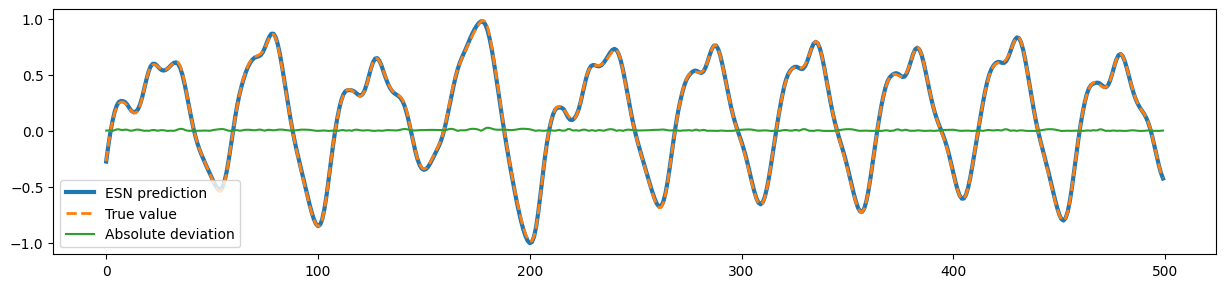

In [20]:
plot_results(y_pred1, y_test1)

$R^2$ and NRMSE :

In [21]:
rsquare(y_test1, y_pred1), nrmse(y_test1, y_pred1)

(0.9997151529876694, 0.004028803196465733)

### 1.2 Make the task harder

Now, let's have a forecasting horizon of 10 timsteps.

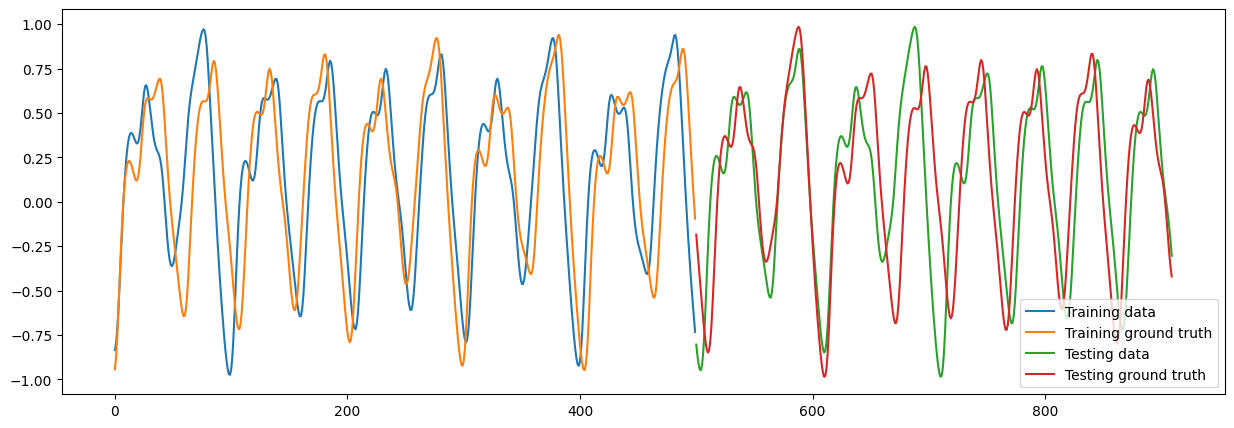

In [22]:
x, y = to_forecasting(X, forecast=100)
X_train2, y_train2 = x[:2000], y[:2000]
X_test2, y_test2 = x[2000:], y[2000:]

plot_train_test(X_train2, y_train2, X_test2, y_test2)

In [23]:
y_pred2 = esn.fit(X_train2, y_train2).run(X_test2)

Running Model-0: 2000it [00:00, 9652.80it/s]<?, ?it/s]
Running Model-0: 100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


Fitting node Ridge-0...


Running Model-0: 410it [00:00, 9043.06it/s]           


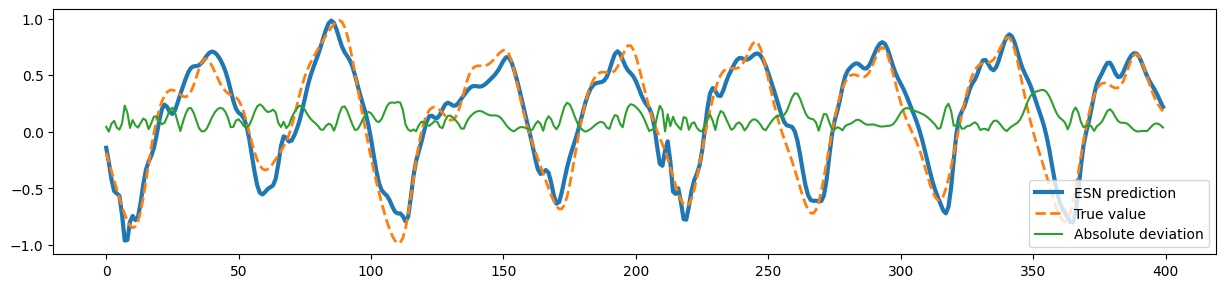

In [24]:
plot_results(y_pred2, y_test2, sample=400)

$R^2$ and NRMSE:

In [25]:
rsquare(y_test2, y_pred2), nrmse(y_test2, y_pred2)

(0.9266906702044402, 0.06647779404293802)

## Chapter 2 : Use generative mode <span id="chapitre2"/>

- Train ESN on a one-timestep-ahead forecasting task.
- Run the ESN on its own predictions (closed loop generative mode)

In [94]:
units = 500
leak_rate = 0.3
spectral_radius = 2
input_scaling = 1.0
connectivity = 0.1      # - density of reservoir internal matrix
input_connectivity = 0.2  # and of reservoir input matrix
regularization = 1e-4
seed = 1234             # for reproducibility

In [95]:
def plot_generation(X_gen, X_t, nb_generations, warming_out=None, warming_inputs=None, seed_timesteps=0):

    plt.figure(figsize=(15, 5))
    if warming_out is not None:
        plt.plot(np.vstack([warming_out, X_gen]), label="Generated timeseries")
    else:
        plt.plot(X_gen, label="Generated timeseries")

    plt.plot(np.arange(nb_generations)+seed_timesteps, X_t, linestyle="--", label="Real timeseries")

    if warming_inputs is not None:
        plt.plot(np.arange(seed_timesteps), warming_inputs, linestyle="--", label="Warmup")

    plt.plot(np.arange(nb_generations)+seed_timesteps, np.abs(X_t - X_gen),
             label="Absolute deviation")

    if seed_timesteps > 0:
        plt.fill_between([0, seed_timesteps], *plt.ylim(), facecolor='lightgray', alpha=0.5, label="Warmup")

    plt.plot([], [], ' ', label=f"$R^2 = {round(rsquare(X_t, X_gen), 4)}$")
    plt.plot([], [], ' ', label=f"$NRMSE = {round(nrmse(X_t, X_gen), 4)}$")
    plt.legend(
    )
    plt.show()

#### Training for one-timestep-ahead forecast

In [96]:
esn, r = reset_esn()

esn(X[0]) # init

denseW = r.W.toarray()
# denseW = denseW * 0.1

denseW = get_forwardized_weights(denseW)

# denseW = denseW + np.identity(denseW.shape[0])
from scipy import sparse

sparseW = sparse.csr_matrix(denseW)

r.W = sparseW

print(r.Win is not None, r.W is not None)

show1 = r.W.toarray()


True True


In [97]:
x, y = to_forecasting(X, forecast=1)
X_train3, y_train3 = x[:2000], y[:2000]
X_test3, y_test3 = x[2000:], y[2000:]

esn = esn.fit(X_train3, y_train3)

Running Model-10: 2000it [00:00, 5870.86it/s]<?, ?it/s]
Running Model-10: 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]


Fitting node Ridge-6...


#### Generative mode

- 100 steps of the real timeseries used as warmup.
- 300 steps generated by the reservoir, without external inputs.

In [98]:
seed_timesteps = 100

warming_inputs = X_test3[:seed_timesteps]

warming_out = esn.run(warming_inputs, reset=True)  # warmup

Running Model-10: 100it [00:00, 4985.68it/s]           


In [99]:
nb_generations = 400

X_gen = np.zeros((nb_generations, 1))
y = warming_out[-1]
for t in range(nb_generations):  # generation
    y = esn(y)
    X_gen[t, :] = y

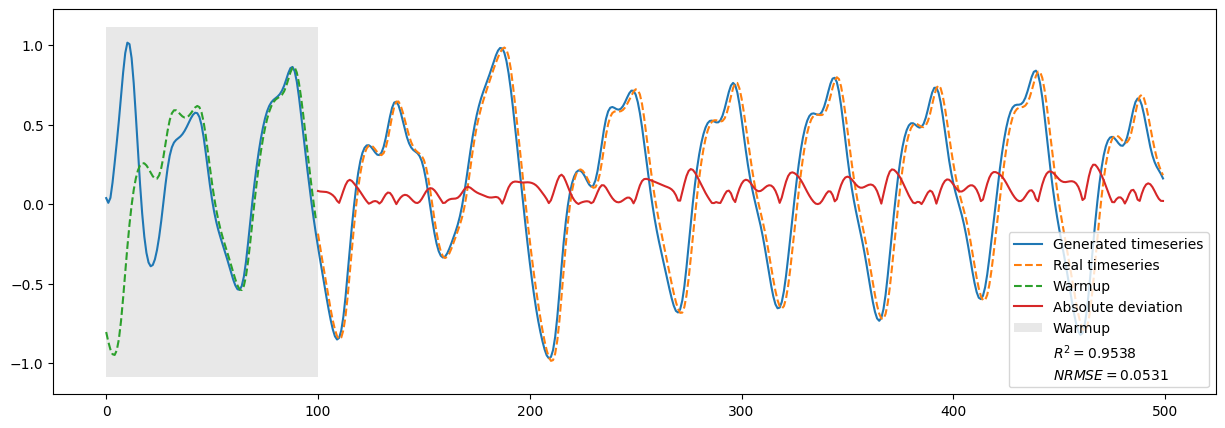

In [100]:
X_t = X_test3[seed_timesteps: nb_generations+seed_timesteps]
plot_generation(X_gen, X_t, nb_generations, warming_out=warming_out,
                warming_inputs=warming_inputs, seed_timesteps=seed_timesteps)

## Chapter 3 : Online learning <span id="chapitre3"/>

Some learning rules allow to update the readout parameters at every timestep of input series.

Using **FORCE** algorithm *(Sussillo and Abott, 2009)*

<div>
    <img src="./static/online.png" width="700">
</div>

In [ ]:
units = 100
leak_rate = 0.3
spectral_radius = 1.25
input_scaling = 1.0
connectivity = 0.1
input_connectivity = 0.2
seed = 1234

In [ ]:
from reservoirpy.nodes import FORCE

reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                      lr=leak_rate, rc_connectivity=connectivity,
                      input_connectivity=input_connectivity, seed=seed)

readout   = FORCE(1)


esn_online = reservoir >> readout

#### Step by step training

In [ ]:
outputs_pre = np.zeros(X_train1.shape)
for t, (x, y) in enumerate(zip(X_train1, y_train1)): # for each timestep of training data:
    outputs_pre[t, :] = esn_online.train(x, y)

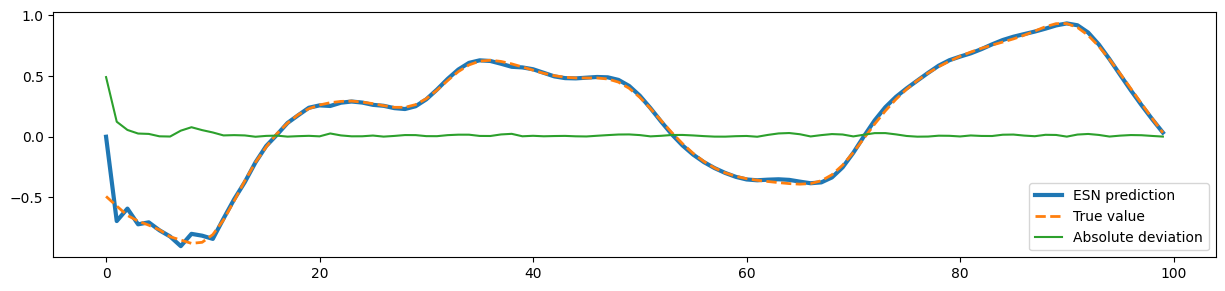

In [ ]:
plot_results(outputs_pre, y_train1, sample=100)

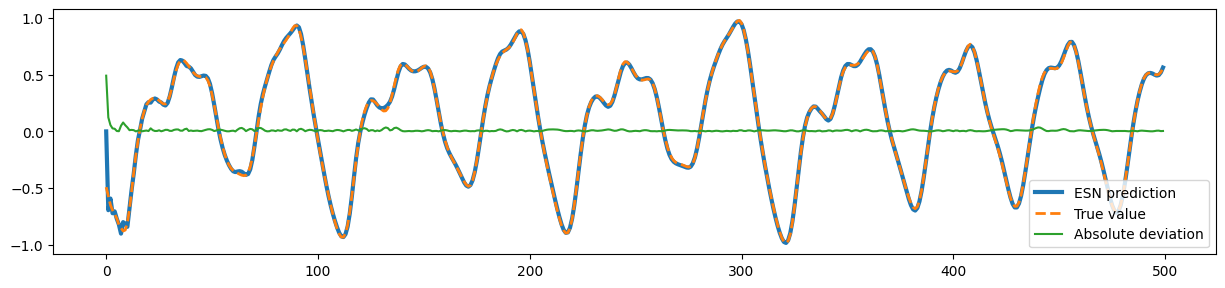

In [ ]:
plot_results(outputs_pre, y_train1, sample=500)

#### Training on a whole timeseries

In [ ]:
reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                      lr=leak_rate, rc_connectivity=connectivity,
                      input_connectivity=input_connectivity, seed=seed)

readout   = FORCE(1)


esn_online = reservoir >> readout

In [ ]:
esn_online.train(X_train1, y_train1)

pred_online = esn_online.run(X_test1)  # Wout est maintenant figée

Running Model-6: 500it [00:00, 10213.42it/s]          


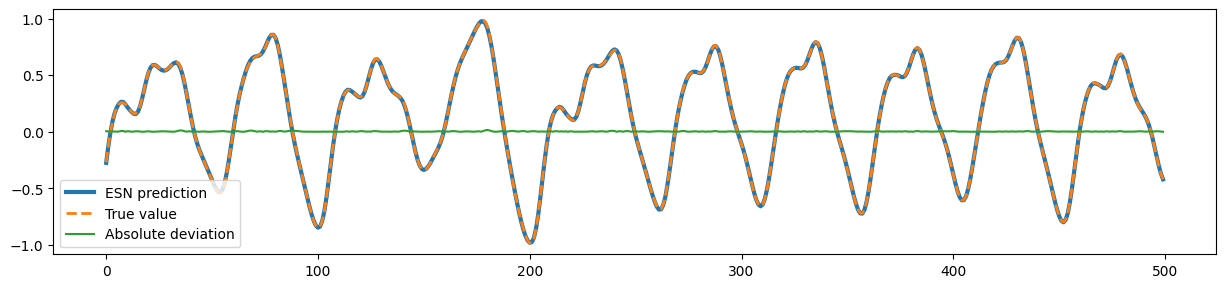

In [ ]:
plot_results(pred_online, y_test1, sample=500)

$R^2$ and NRMSE:

In [ ]:
rsquare(y_test1, pred_online), nrmse(y_test1, pred_online)

(0.9999449763543614, 0.0017706977856641471)

## Other timeseries

Try out the other choatic timeseries included in ReservoirPy: Lorenz chaotic attractor, Hénon map, Logistic map, Double scroll attractor...

## Chapter 4:  use case in the wild: robot falling <span id="chapitre4"/>

Data for this use case can be found on Zenodo: https://zenodo.org/record/5900966

<div>
    <img src="./static/sigmaban.gif" width="500">
</div>

#### Chargement et préparation des données

In [ ]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from joblib import delayed, Parallel
from tqdm import tqdm

In [ ]:
features = ['com_x', 'com_y', 'com_z', 'trunk_pitch', 'trunk_roll', 'left_x', 'left_y',
            'right_x', 'right_y', 'left_ankle_pitch', 'left_ankle_roll', 'left_hip_pitch',
            'left_hip_roll', 'left_hip_yaw', 'left_knee', 'right_ankle_pitch',
            'right_ankle_roll', 'right_hip_pitch', 'right_hip_roll',
            'right_hip_yaw', 'right_knee']

prediction = ['fallen']
force = ['force_orientation', 'force_magnitude']

In [ ]:
files = glob.glob("./r4-data/experiments/*")
dfs = []

with Parallel(n_jobs=-1) as parallel:
    dfs = parallel(delayed(pd.read_csv)(f, compression="gzip", header=0, sep=",") for f in tqdm(files))

0it [00:00, ?it/s]


In [ ]:
X = []
Y = []
F = []
for i, df in enumerate(dfs):
    X.append(df[features].values)
    Y.append(df[prediction].values)
    F.append(df["force_magnitude"].values)

In [ ]:
Y_train = []
for y in Y:
    y_shift = np.roll(y, -500)
    y_shift[-500:] = y[-500:]
    Y_train.append(y_shift)

In [ ]:
def plot_robot(Y, Y_train, F):
    plt.figure(figsize=(10, 7))
    plt.plot(Y_train[1], label="Objective")
    plt.plot(Y[1], label="Fall indicator")
    plt.plot(F[1], label="Applied force")
    plt.legend()
    plt.show()

In [ ]:
plot_robot(Y, Y_train, F)

IndexError: list index out of range

<Figure size 1000x700 with 0 Axes>

#### Training the ESN

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y_train, test_size=0.2, random_state=42)

In [ ]:
from reservoirpy.nodes import ESN

reservoir = Reservoir(300, lr=0.5, sr=0.99, input_bias=False)
readout   = Ridge(1, ridge=1e-3)
esn = ESN(reservoir=reservoir, readout=readout, workers=-1)  # version distribuée

In [ ]:
esn = esn.fit(X_train, y_train)

In [ ]:
res = esn.run(X_test)

In [ ]:
from reservoirpy.observables import rmse
scores = []
for y_t, y_p in zip(y_test, res):
    score = rmse(y_t, y_p)
    scores.append(score)


filt_scores = []
for y_t, y_p in zip(y_test, res):
    y_f = y_p.copy()
    y_f[y_f > 0.5] = 1.0
    y_f[y_f <= 0.5] = 0.0
    score = rmse(y_t, y_f)
    filt_scores.append(score)

In [ ]:
def plot_robot_results(y_test, y_pred):
    for y_t, y_p in zip(y_test, y_pred):
        if y_t.max() > 0.5:
            y_shift = np.roll(y, 500)
            y_shift[:500] = 0.0

            plt.figure(figsize=(7, 5))
            plt.plot(y_t, label="Objective")
            plt.plot(y_shift, label="Fall")
            plt.plot(y_p, label="Prediction")
            plt.legend()
            plt.show()
            break

In [ ]:
plot_robot_results(y_test, res)

In [ ]:
print("Averaged RMSE :", f"{np.mean(scores):.4f}", "±", f"{np.std(scores):.5f}")
print("Averaged RMSE (with threshold) :", f"{np.mean(filt_scores):.4f}", "±", f"{np.std(filt_scores):.5f}")

## Chapitre 5: use case in the wild: canary song decoding <span id="chapitre5"/>

Data for this use case can be found on Zenodo :
https://zenodo.org/record/4736597

<div>
    <img src="./static/canary.png" width="500">
</div>

In [ ]:
from IPython.display import Audio

audio = Audio(filename="./static/song.wav")

In [ ]:
display(audio)

Several temporal motifs to classify: the *phrases*


- There is one label per phrase type.
- A *SIL* label denotes silence. Silence also needs to be detected to segment songs properly.

In [ ]:
im = plt.imread("./static/canary_outputs.png")
plt.figure(figsize=(15, 15)); plt.imshow(im); plt.axis('off'); plt.show()

#### Loading and data preprocessing

In [ ]:
import os
import glob
import math
import pandas as pd
import librosa as lbr

from tqdm import tqdm
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import OneHotEncoder

win_length = 1024
n_fft = 2048
hop_length = 512
fmin = 500
fmax = 8000
lifter = 40
n_mfcc = 13


def load_data(directory, max_songs=450):
    audios = sorted(glob.glob(directory + "/**/*.wav", recursive=True))
    annotations = sorted(glob.glob(directory + "/**/*.csv", recursive=True))


    X = []
    Y = []
    vocab = set()

    max_songs = min(len(audios), max_songs)

    for audio, annotation, _ in tqdm(zip(audios, annotations, range(max_songs)), total=max_songs):
        df = pd.read_csv(annotation)
        wav, rate = lbr.load(audio, sr=None)
        x = lbr.feature.mfcc(y=wav, sr=rate,
                              win_length=win_length, hop_length=hop_length,
                              n_fft=n_fft, fmin=fmin, fmax=fmax, lifter=lifter,
                              n_mfcc=n_mfcc)
        delta = lbr.feature.delta(x, mode="wrap")
        delta2 = lbr.feature.delta(x, order=2, mode="wrap")

        X.append(np.vstack([x, delta, delta2]).T)

        y = [["SIL"]] * x.shape[1]

        for annot in df.itertuples():
            start = max(0, round(annot.start * rate / hop_length))
            end = min(x.shape[1], round(annot.end * rate / hop_length))
            y[start:end] = [[annot.syll]] * (end - start)
            vocab.add(annot.syll)

        Y.append(y)

    return X, Y, list(vocab)

X, Y, vocab = load_data("./canary-data")

#### One-hot encoding of phrase labels

In [ ]:
one_hot = OneHotEncoder(categories=[vocab], sparse=False)

Y = [one_hot.fit_transform(np.array(y)) for y in Y]

We will conduct a first preliminary trial on 100 songs (90 for training, 10 for testing).

The dataset contains 459 songs in total. You may improve your results by adding more data and perfoming cross validation.

In [ ]:
X_train, y_train = X[:-10], Y[:-10]
X_test, y_test = X[-10:], Y[-10:]

#### ESN training

We use the special node `ESN` to train our model. This node allows parallelization of states computations, which will speed up the training on this large dataset.

In [ ]:
from reservoirpy.nodes import ESN

units = 1000
leak_rate = 0.05
spectral_radius = 0.5
inputs_scaling = 0.001
connectivity = 0.1
input_connectivity = 0.1
regularization = 1e-5
seed = 1234


reservoir = Reservoir(units, sr=spectral_radius,
                      lr=leak_rate, rc_connectivity=connectivity,
                      input_connectivity=input_connectivity, seed=seed)

readout = Ridge(ridge=regularization)


esn = ESN(reservoir=reservoir, readout=readout, workers=-1)

In [ ]:
esn = esn.fit(X_train, y_train)

In [ ]:
outputs = esn.run(X_test)

In [ ]:
from sklearn.metrics import accuracy_score

scores = []
for y_t, y_p in zip(y_test, outputs):
    targets = np.vstack(one_hot.inverse_transform(y_t)).flatten()

    top_1 = np.argmax(y_p, axis=1)
    top_1 = np.array([vocab[t] for t in top_1])

    accuracy = accuracy_score(targets, top_1)

    scores.append(accuracy)

In [ ]:
scores  # for each song in the testing set

In [ ]:
print("Average accuracy :", f"{np.mean(scores):.4f}", "±", f"{np.std(scores):.5f}")
